In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


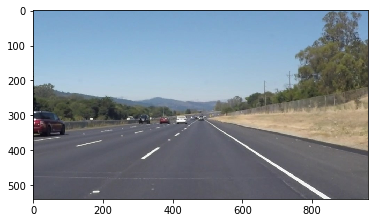

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

In [3]:
def manage_yellow(image):
    # Convert BGR to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # define range of yellow color in HSV
    lower_yellow = np.array([20,100,200])
    upper_yellow = np.array([30,255,255])

    # Threshold the HSV image to get only yellow colors
    mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    
    return mask

In [4]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255,0,0], thickness=2, draw_point=0):
    """
    function draw_lines takes lines (segments) detected during hough transformation,
    filter them so to retain just lines with absolute value of curve more than 0.5
    and based on the sign of the carve assigns the tops of the lines to the left and
    right lane
    sub function draw_points visualizes tops of the lines (segments)
    I'm using polyfit function from numpy to make a linear extrapolation of the lane
    curve using the tops
    
    """
    def draw_points():
        #draw points of detected lines
        for i in range(len(left_x)):
            cv2.circle(img,(left_x[i],left_y[i]), 10, (0,0,255), -1)
        for i in range(len(right_x)):
            cv2.circle(img,(right_x[i],right_y[i]), 10, (0,255,0), -1)    
        
    left_x = []
    left_y = []
    
    right_x = []
    right_y = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            if (y2-y1)/(x2-x1) > 0.5 or (y2-y1)/(x2-x1) < -0.5:
                if (y2-y1)/(x2-x1)<0 and x1<img.shape[1]/2:
                    left_x.append(x1)
                    left_x.append(x2)
                    left_y.append(y1)
                    left_y.append(y2)
                elif (y2-y1)/(x2-x1)>=0 and x1>img.shape[1]/2:
                    right_x.append(x1)
                    right_x.append(x2)
                    right_y.append(y1)
                    right_y.append(y2)
      
    if draw_point==1:
        draw_points()
    if left_x and left_y:
        left = np.poly1d(np.polyfit(left_x,left_y,1))
        left_x_final = []
        left_y_final = []

        for i in range(int(0.12*img.shape[1]),int(0.46*img.shape[1])):
            if (left(i)<img.shape[0] and left(i)>0):
                left_x_final.append(i)
                left_y_final.append(int(left(i)))

        for i in range(len(left_x_final)-1):
            cv2.line(img, (left_x_final[i], left_y_final[i]), \
                     (left_x_final[i+1], left_y_final[i+1]), color, 5)
    
    if right_x and right_y:    
        right = np.poly1d(np.polyfit(right_x,right_y,1))
        right_x_final = []
        right_y_final = []

        for i in range(int(0.56*img.shape[1]), int(0.95*img.shape[1])):
            if (right(i)<img.shape[0] and right(i)>0):
                right_x_final.append(i)
                right_y_final.append(int(right(i)))

        for i in range(len(right_x_final)-1):
            cv2.line(img, (right_x_final[i], right_y_final[i]), \
                     (right_x_final[i+1], right_y_final[i+1]), color, 5)

        
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines,thickness=10,draw_point=0)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [5]:
import os
test_images = os.listdir("test_images/")
if '.DS_Store' in test_images:
    test_images.remove('.DS_Store')

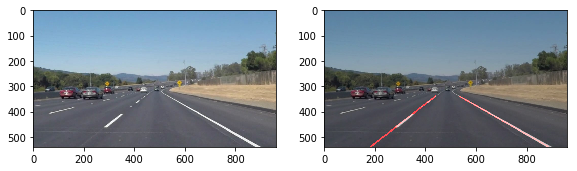

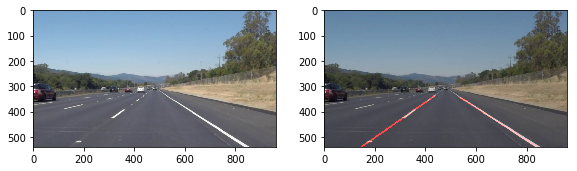

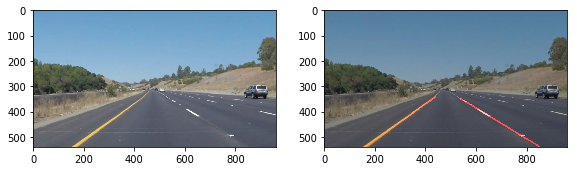

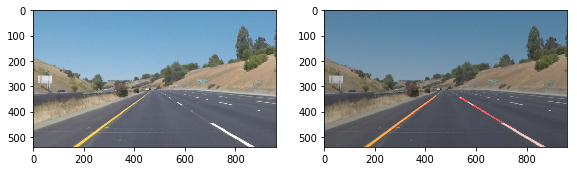

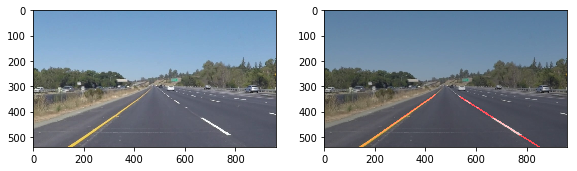

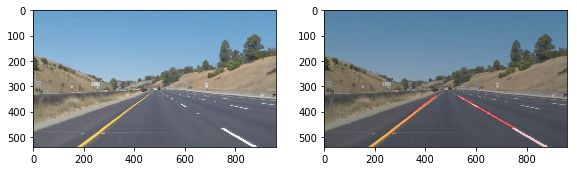

In [9]:
def image_processing(image, draw_mask_v = 0):
    """
    function image_processing is a pipeline of image transformations:
    1) transformation to grayscale
    2) image smoothing using Gaussian filter
    3) edge detection using Canny detector
    3*) adding yellow lanes to edges image
    4) excluding everything out of region of interest's polygon
    5) applying hough transformation
    6) combining initial image with results
    """
    def draw_mask():
        #visualizing mask polygon
        cv2.line(image, A, B,[255, 0, 0], 5)
        cv2.line(image, B, C, [255, 0, 0], 5)
        cv2.line(image, C, D, [255, 0, 0], 5)
        cv2.line(image, D, A, [255, 0, 0], 5)

    gray = grayscale(image)
    gray_blur = gaussian_blur(gray, 5)
    edges = canny(gray_blur, 50, 150)
    edges = cv2.bitwise_or(edges, manage_yellow(image)) 

    imshape = image.shape

    A = (int(0.11*imshape[1]), imshape[0])
    B = (int(0.44*imshape[1]), int(0.6*imshape[0]))
    C = (int(0.56*imshape[1]), int(0.6*imshape[0]))
    D = (int(0.95*imshape[1]), imshape[0])
    vertices = np.array([[A, B, C, D]], dtype=np.int32)

    if draw_mask_v == 1:
        draw_mask()

    canny_img = region_of_interest(edges, vertices)

    rho = 1
    theta = np.pi / 180
    threshold = 20
    min_line_len = 20
    max_line_gap = 300

    hough = hough_lines(canny_img, rho, theta, threshold, min_line_len, max_line_gap)
    final = weighted_img(hough, image, α=0.8, β=1., λ=0.)

    return edges, canny_img, hough, final

for name in test_images:
    image = mpimg.imread('test_images/'+name)
    edges, canny_img, hough, final = image_processing(image)
        
    f = plt.figure(figsize=(20,10))

    f.add_subplot(1, 4, 1)
    plt.imshow(np.asarray(image))

    f.add_subplot(1,4,2)
    plt.imshow(np.asarray(final))

In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [15]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    _,_,_, result = image_processing(image)
    return result

In [16]:
from moviepy.editor import VideoFileClip
white_output = 'test_videos/Yellow.mp4'
clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos/Yellow.mp4
[MoviePy] Writing video test_videos/Yellow.mp4


100%|█████████▉| 681/682 [00:27<00:00, 25.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos/Yellow.mp4 

CPU times: user 31.6 s, sys: 1.25 s, total: 32.8 s
Wall time: 27.9 s
